In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

columns = ["id", "diagnosis"]
x_columns = []
for i in range(1, 31):
    columns.append("feature_" + str(i))
    x_columns.append("feature_" + str(i))

df = pd.read_csv("data/wdbc.data", names=columns)

## Data preprocessing
Apply MinMaxScaler to the features to minimize the effect of features with large values

In [2]:
features = df[x_columns]
features = MinMaxScaler().fit_transform(features)

target = df["diagnosis"]
target_name = df["diagnosis"].copy()
target = target.map({"M": 1, "B": 0})

## K-Means implementation

In [3]:
def k_means(data, k, max_iters=100):
    cent = data[np.random.choice(data.shape[0], k, replace=False)]
    
    label = np.array([])
    
    for _ in range(max_iters):
        # Step 2: Assign data points to clusters
        distances = np.sqrt(((data - cent[:, np.newaxis]) ** 2).sum(axis=2))
        label = np.argmin(distances, axis=0)

        # Step 3: Update centroids
        new_centroids = np.array([data[label == i].mean(axis=0) for i in range(k)])

        # Check for convergence
        if np.allclose(cent, new_centroids):
            break

        cent = new_centroids

    return cent, label

In [4]:
def calculate_accuracy(l, t):
    acc = np.mean(l == t)
    if acc < 0.5:
        acc = 1 - acc

    return acc

## Elbow method

In [5]:
def elbow_method(data, max_k=10, title="Elbow"):
    sum_squared_err = []

    for current_k in range(1, max_k + 1):
        centroids, labels = k_means(data, k=current_k)
        sum_squared_err.append(np.sum((data - centroids[labels]) ** 2))

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_k + 1), sum_squared_err, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Sum of Squared Distances')
    plt.title(title)
    plt.grid()
    plt.show()

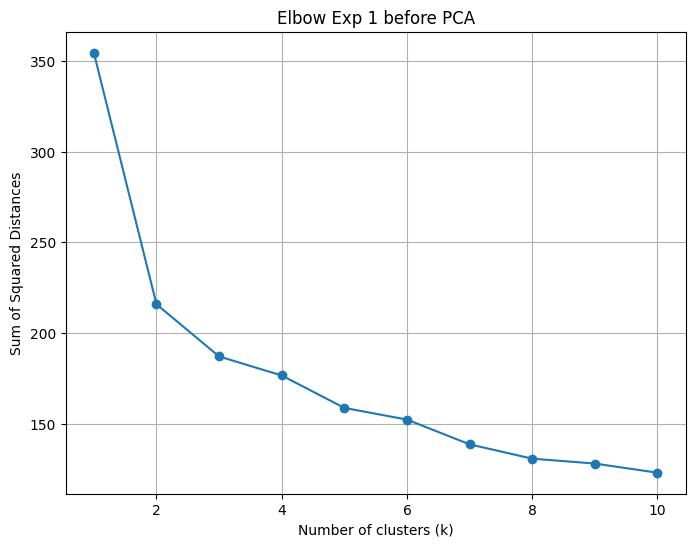

In [6]:
elbow_method(features, title="Elbow Exp 1 before PCA")

## Observations
We can see that the elbow is at k=2, which is the number of classes in the dataset.

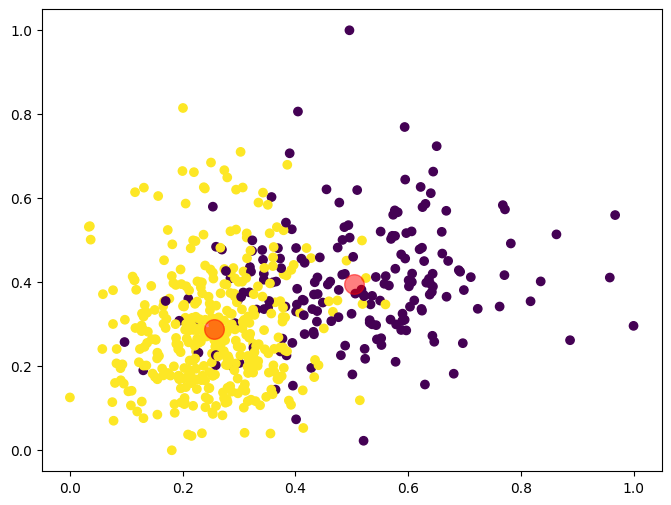

Accuracy: 92.79%


In [7]:
centroids, labels = k_means(features, k=2)

# plt
plt.figure(figsize=(8, 6))
plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.5)
plt.show()

# Calculate accuracy
accuracy = calculate_accuracy(labels, target)

print("Accuracy: " + str(round(accuracy * 100, 2)) + "%")

sse_exp_1 = np.sum((features - centroids[labels]) ** 2) 

# PCA implementation

In [8]:
def pca(data, num_components):
    # Step 1: Standardize the data
    data_mean = np.mean(data, axis=0)
    standardized_data = data - data_mean

    # Step 2: Compute the covariance matrix
    covariance_matrix = np.cov(standardized_data, rowvar=False)

    # Step 3: Calculate eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Step 4: Select top k eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    top_k_indices = sorted_indices[:num_components]
    principal_components = eigenvectors[:, top_k_indices]

    # Step 5: Project the data onto the selected principal components
    transformed_data = np.dot(standardized_data, principal_components)

    return transformed_data

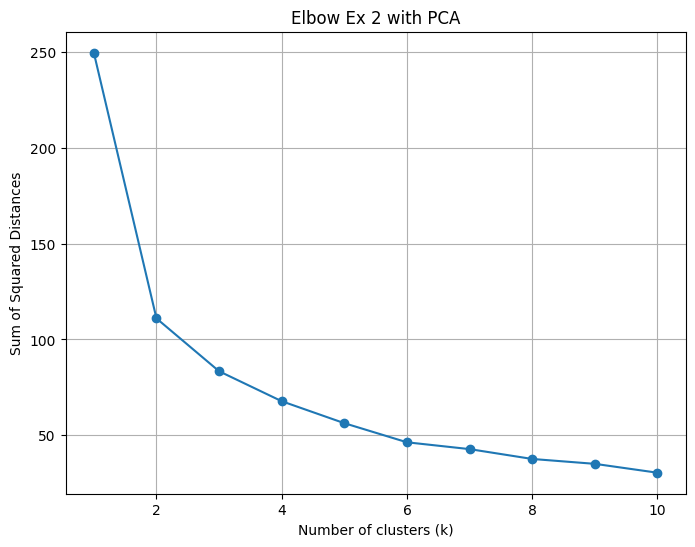

In [9]:
t_data = pca(features, num_components=2)

elbow_method(t_data, title="Elbow Ex 2 with PCA")

In [10]:
k = 2
centroids, labels = k_means(t_data, k)

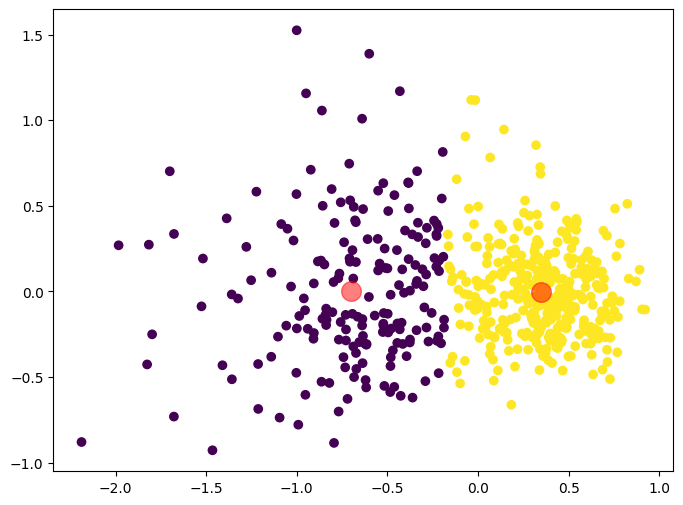

Accuracy: 92.79%


In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(t_data[:, 0], t_data[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.5)
plt.show()

sse_exp_2 = np.sum((t_data - centroids[labels]) ** 2)

accuracy = calculate_accuracy(labels, target)
print("Accuracy: " + str(round(accuracy * 100, 2)) + "%")

# Comparing Sum of Squared error
## Expectations
### Experiment 1 (Without PCA):
- SSE reflects distances in the original feature space without dimensionality reduction.
- Higher SSE may indicate more scattered or dispersed clusters due to the higher dimensionality.

### Experiment 2 (With PCA):
- Lower SSE compared to Experiment 1 due to dimensionality reduction.
- PCA attempts to retain the most relevant information in fewer dimensions.
- Lower SSE suggests that clustering in a reduced-dimensional space captures the inherent structure better.

In [12]:
print(f"SSE Experiment 1 (Without PCA): {round(sse_exp_1, 2)}")
print(f"SSE Experiment 2 (With PCA): {round(sse_exp_2, 2)}")

SSE Experiment 1 (Without PCA): 215.84
SSE Experiment 2 (With PCA): 110.97


## Trying different principale components

[[-1.38702121  0.42689533 -0.54170264]
 [-0.46230825 -0.55694674 -0.20517458]
 [-0.95462147 -0.10970115 -0.1478484 ]
 ...
 [-0.22631131 -0.28794577  0.31522402]
 [-1.67783369  0.33594595  0.29611601]
 [ 0.90506804 -0.10410875  0.38285992]]
[[-1.38702121e+00  4.26895326e-01 -5.41702643e-01  4.84832190e-02]
 [-4.62308252e-01 -5.56946737e-01 -2.05174584e-01 -4.28298503e-02]
 [-9.54621472e-01 -1.09701150e-01 -1.47848400e-01 -1.06752717e-03]
 ...
 [-2.26311313e-01 -2.87945766e-01  3.15224024e-01 -1.17468080e-02]
 [-1.67783369e+00  3.35945955e-01  2.96116006e-01 -1.56304843e-01]
 [ 9.05068041e-01 -1.04108746e-01  3.82859921e-01  6.83605121e-02]]
[[-1.38702121e+00  4.26895326e-01 -5.41702643e-01  4.84832190e-02
   7.21980726e-02  1.90816932e-01]
 [-4.62308252e-01 -5.56946737e-01 -2.05174584e-01 -4.28298503e-02
  -1.61111183e-02  1.56035119e-02]
 [-9.54621472e-01 -1.09701150e-01 -1.47848400e-01 -1.06752717e-03
   3.37982749e-02  6.90615180e-02]
 ...
 [-2.26311313e-01 -2.87945766e-01  3.1522402

C:\Users\zeyad\AppData\Local\Temp\ipykernel_11616\2784671620.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax_original.scatter(pca_points[:, 0], pca_points[:, 1], label="M", cmap='viridis', alpha=0.5)
C:\Users\zeyad\AppData\Local\Temp\ipykernel_11616\2784671620.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax_original.scatter(pca_points[:, 0], pca_points[:, 1], label="B", cmap='viridis', alpha=0.5)


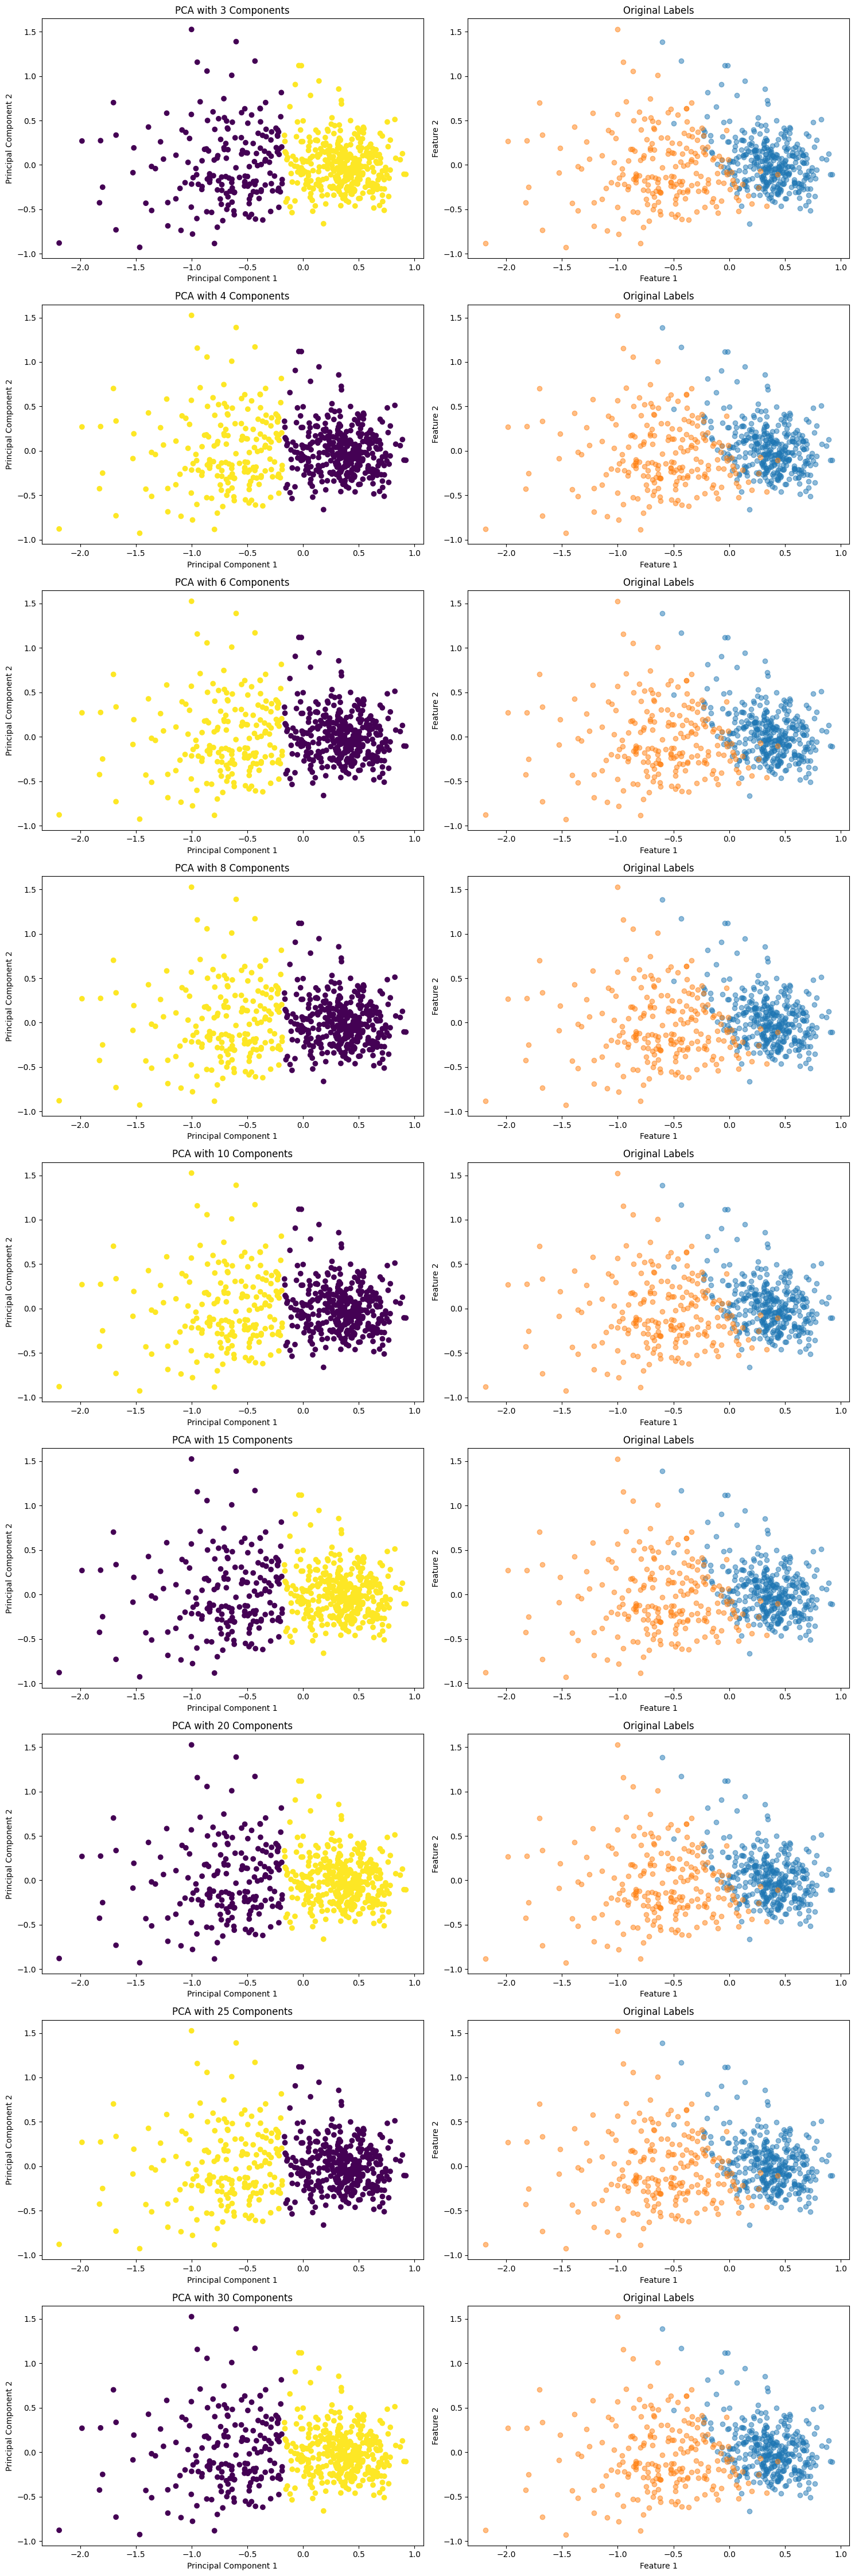

In [67]:
num_components_list = [3, 4, 6, 8, 10, 15, 20, 25, 30]
num_cols = 2

num_plots = len(num_components_list)*2
num_rows = (num_plots - 1) // num_cols + 1  # Calculate the number of rows needed

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

i=0
for idx, n_components in enumerate(num_components_list):
    t_data = pca(features, n_components)
    centroids, labels_pca = k_means(t_data, k=2)
    
    row_idx = idx 
    col_idx=i
    ax = axs[row_idx, col_idx] if num_plots > 1 else axs

    ax.scatter(t_data[:, 0], t_data[:, 1], c=labels_pca, cmap='viridis')
    ax.set_title(f'PCA with {n_components} Components')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')

    # Plot original labels
    ax_original = axs[row_idx, col_idx + 1]
    pca_points = t_data[np.where(target == 0)]
    ax_original.scatter(pca_points[:, 0], pca_points[:, 1], label="M", cmap='viridis', alpha=0.5)
    pca_points = t_data[np.where(target == 1)]
    ax_original.scatter(pca_points[:, 0], pca_points[:, 1], label="B", cmap='viridis', alpha=0.5)
    ax_original.set_title('Original Labels')
    ax_original.set_xlabel('Feature 1')
    ax_original.set_ylabel('Feature 2')
# Hide empty subplots if any
for i in range(num_plots, num_rows * num_cols):
    ax = axs.flatten()[i]
    ax.axis('off')

plt.tight_layout()
plt.show()

# Visualizing the results 

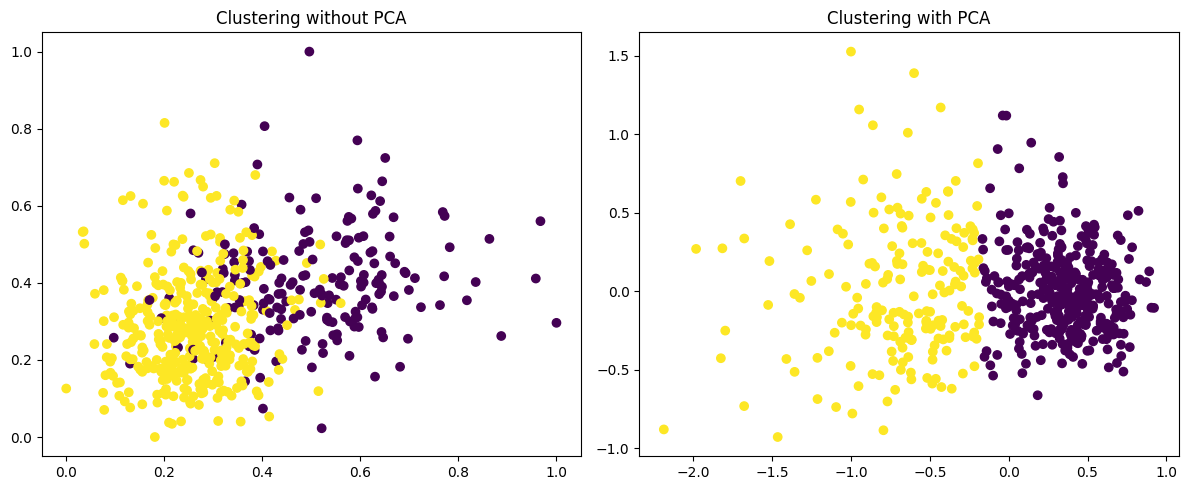

In [154]:
# Experiment 1: Without PCA

plt.figure(figsize=(12, 5))

_, labels = k_means(features, k=2)

plt.subplot(1, 2, 1)
plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis')
plt.title('Clustering without PCA')

# Experiment 2: With PCA
t_data = pca(features, 2)
_, labels_pca = k_means(t_data, k=2)

plt.subplot(1, 2, 2)
plt.scatter(t_data[:, 0], t_data[:, 1], c=labels_pca, cmap='viridis')
plt.title('Clustering with PCA')

plt.tight_layout()
plt.show()